# PyBroom Example - Multiple Datasets

Example usage for `pybroom`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'  # for hi-dpi displays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import lmfit
print('lmfit: %s' % lmfit.__version__)

lmfit: 0.9.4rc1-37-ga9436eb-dirty


In [2]:
import scipy.optimize as so

In [3]:
sns.set_style('whitegrid')

In [4]:
import pybroom as br

# Create Noisy Data

Simulate *N* datasets which are indentical except for the additive noise.

In [5]:
N = 20

In [6]:
n = 1000
d1 = np.random.randn(20, int(0.25*n))*0.5 + 1
d2 = np.random.randn(20, int(0.75*n))*0.5 - 2
d = np.hstack((d1, d2))

In [7]:
ds = pd.DataFrame(data=d.T, columns=range(20)).stack().reset_index()
ds.columns = ['sample', 'dataset', 'data']
ds.head()

,sample,dataset,data
0,0,0,1.196230
1,0,1,-0.397948
2,0,2,1.181940
3,0,3,0.816074
4,0,4,0.404468


In [8]:
from matplotlib.pylab import normpdf as gauss_pdf

# Model PDF to be maximized
def model_pdf(x, a2, mu1, mu2, sig1, sig2):
    a1 = 1 - a2
    #assert np.abs(a1 + a2 - 1) < 1e-3
    return (a1 * gauss_pdf(x, mu1, sig1) + 
            a2 * gauss_pdf(x, mu2, sig2))

def model_pdf_df(x, p, var_name='name', var_value='value'):
    """Takes parameters in DatFrame `p` in tidy (i.e. long) format.
    
    Parameter names are in column `var_name` and values in column
    `var_value`.
    """
    params = (float(p.loc[(p[var_name] == var), var_value])
              for var in ('a2', 'mu1', 'mu2', 'sig1', 'sig2'))
    return model_pdf(x, *params)

# Function to be minimized by lmfit
def log_likelihood_lmfit(params, x):
    a2 = params['a2']
    mu1 = params['mu1']
    mu2 = params['mu2']
    sig1 = params['sig1']
    sig2 = params['sig2']
    return -np.log(model_pdf(x, a2, mu1, mu2, sig1, sig2))

In [9]:
def dict_from_tidy_df(df, var_name='name', var_value='value'):
    """Make a messy DataFrame from a tidy one
    """
    return {var: float(p.loc[(p[var_name] == var), var_value])
            for var in ('a2', 'mu1', 'mu2', 'sig1', 'sig2')}

def model_pdf_df(x, p, var_name='name', var_value='value'):
    """Takes parameters in DatFrame `p` in tidy (i.e. long) format.
    
    Parameter names are in column `var_name` and values in column
    `var_value`.
    """
    params = dict_from_tidy_df(df, var_name, var_value)
    return model_pdf(x, **params)

In [41]:
#(dt[var_name] == n) * (dt['dataset'] == i)

In [12]:
var_name = 'name'
var_value = 'value'

In [13]:
for i in range(d.shape[0]):
    pvals = {n: float(dt.loc[ (dt[var_name] == n) * (dt['dataset'] == i), 'value' ])
             for n in pnames}
    #plt.plot(x, model_pdf(x, **pvals), 'k', lw=1, alpha=0.2);

NameError: name 'pnames' is not defined

NameError: name 'dt' is not defined

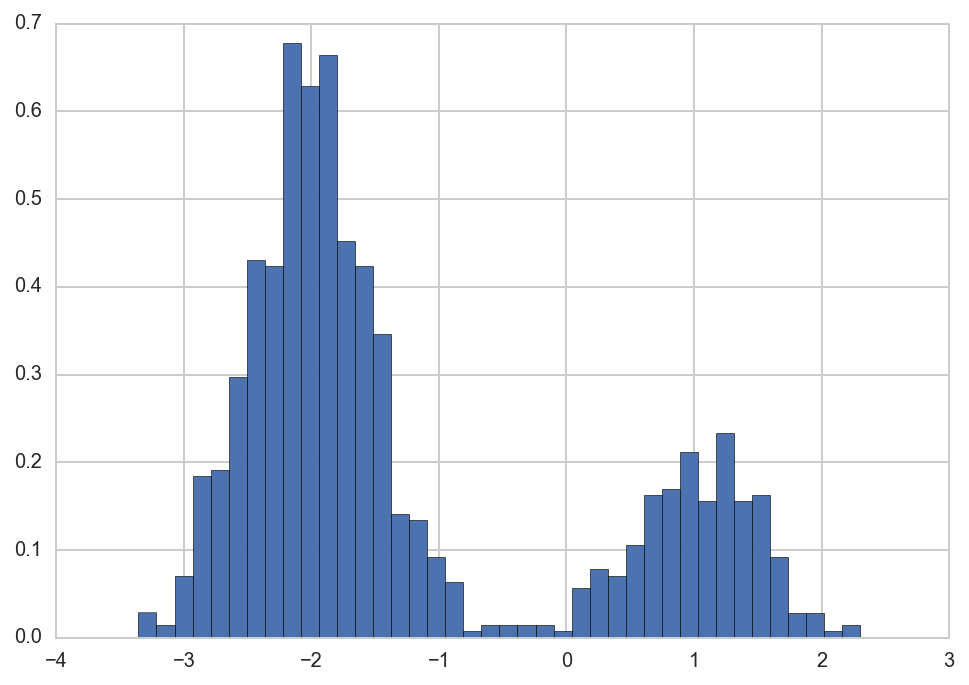

In [11]:
counts, bins, _ = plt.hist(d[0], bins=40, normed=True)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
plt.plot(x, model_pdf(x, **br.tidy_to_dict(dt)), 'k', lw=3);

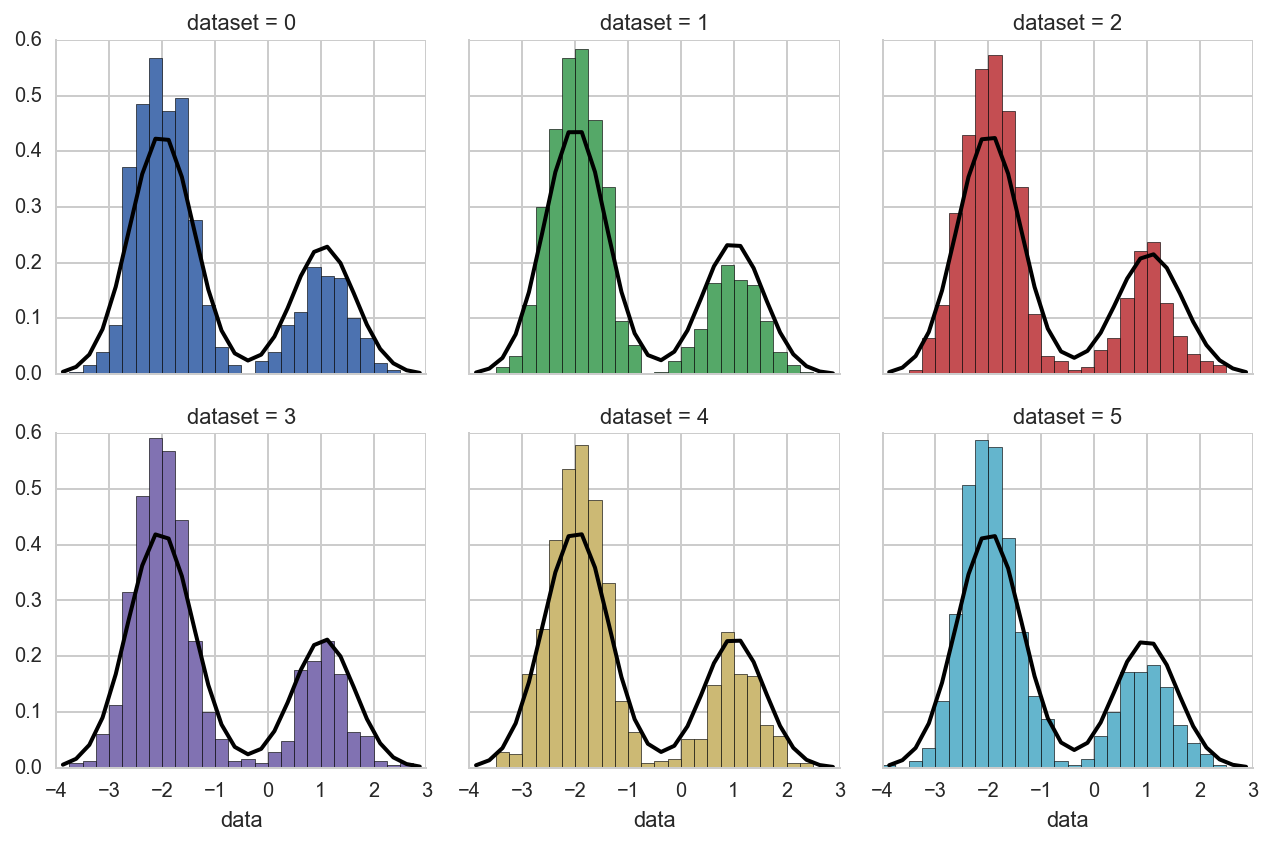

In [16]:
bins = np.arange(-4, 3.01, 0.25)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
grid = sns.FacetGrid(ds.query('dataset < 6'), col='dataset', hue='dataset', col_wrap=3)
grid.map(plt.hist, 'data', bins=bins, normed=True);
for i, ax in enumerate(grid.axes):
    y = model_pdf_df(x, dt.query('dataset == %d' % i))
    ax.plot(x, y, lw=2, color='k')

# Model Fitting

## Single-peak model

In [11]:
model1 = lmfit.models.GaussianModel()

In [12]:
Results1 = [model1.fit(y, x=x) for y in Y_data]

## Two-peaks model

In [13]:
params = model.make_params(p1_center=0, p2_center=3, 
                           p1_sigma=0.5, p2_sigma=1, 
                           p1_amplitude=1, p2_amplitude=2)

In [14]:
Results = [model.fit(y, x=x, params=params) for y in Y_data]

Fit result from an lmfit `Model` can be inspected with
with `fit_report` or `params.pretty_print()`:

In [15]:
#print(Results[0].fit_report())
#Results[0].params.pretty_print()

These methods are convenient but extracting the data
from the lmfit object requires some work and the knowledge
of lmfit object structure.

`pybroom` help in this task, extracting data from fit results and
returning pandas DataFrame in tidy format that can be 
much more easily manipulated, filtered and plotted.

## Glance

A summary of the two-peaks model fit:

In [16]:
dg = br.glance(Results)

dg.drop('name', 1).drop('message', 1).head()

,method,num_params,num_data_points,chisqr,redchi,AIC,BIC,num_func_eval,success,item
0,leastsq,6,101,0.92849,0.00977358,-455.435,-439.745,116,True,0
1,leastsq,6,101,0.75696,0.007968,-476.065,-460.374,60,True,1
2,leastsq,6,101,0.775396,0.00816206,-473.634,-457.943,61,True,2
3,leastsq,6,101,0.726399,0.00764631,-480.227,-464.536,60,True,3
4,leastsq,6,101,0.81217,0.00854915,-468.954,-453.263,80,True,4


A summary of the one-peak model fit:

In [17]:
dg1 = br.glance(Results1)

dg1.drop('name', 1).drop('message', 1).head()

,method,num_params,num_data_points,chisqr,redchi,AIC,BIC,num_func_eval,success,item
0,leastsq,3,101,1.70685,0.0174168,-403.082,-395.237,57,True,0
1,leastsq,3,101,2.05413,0.0209605,-384.377,-376.531,87,True,1
2,leastsq,3,101,1.5391,0.0157051,-413.531,-405.685,139,True,2
3,leastsq,3,101,1.33742,0.0136471,-427.717,-419.872,71,True,3
4,leastsq,3,101,1.69279,0.0172734,-403.917,-396.072,143,True,4


## Tidy

Tidy fit results for all the parameters:

In [18]:
dt = br.tidy(Results, var_name='dataset')

Let's see the results for a single dataset:

In [19]:
dt.query('dataset == 0')

,name,value,min,max,vary,expr,stderr,init_value,dataset
0,p1_amplitude,1.23114,-inf,inf,True,None,0.0759018,1,0
1,p1_center,-0.949446,-inf,inf,True,None,0.038805,0,0
2,p1_fwhm,1.28768,-inf,inf,False,2.3548200*p1_sigma,0.0921372,NaN,0
3,p1_height,0.898193,-inf,inf,False,0.3989423*p1_amplitude/p1_sigma,0.0551081,NaN,0
4,p1_sigma,0.546826,0,inf,True,None,0.039127,0.5,0
5,p2_amplitude,0.606827,-inf,inf,True,None,0.0837929,2,0
6,p2_center,1.9718,-inf,inf,True,None,0.105973,3,0
7,p2_fwhm,1.57043,-inf,inf,False,2.3548200*p2_sigma,0.252062,NaN,0
8,p2_height,0.363005,-inf,inf,False,0.3989423*p2_amplitude/p2_sigma,0.0499464,NaN,0
9,p2_sigma,0.666902,0,inf,True,None,0.107041,1,0


or for a single parameter across datasets:

In [20]:
dt.query('name == "p1_center"').head()

,name,value,min,max,vary,expr,stderr,init_value,dataset
1,p1_center,-0.949446,-inf,inf,True,None,0.038805,0,0
11,p1_center,-0.999412,-inf,inf,True,None,0.0379914,0,1
21,p1_center,-0.993088,-inf,inf,True,None,0.034416,0,2
31,p1_center,-1.01566,-inf,inf,True,None,0.0417191,0,3
41,p1_center,-1.01634,-inf,inf,True,None,0.0336505,0,4


In [21]:
dt.query('name == "p1_center"')['value'].std()

0.037277014520793891

In [22]:
dt.query('name == "p2_center"')['value'].std()

0.21715257456740708

Note that there is a much larger error in fitting `p2_center`
than `p1_center`.

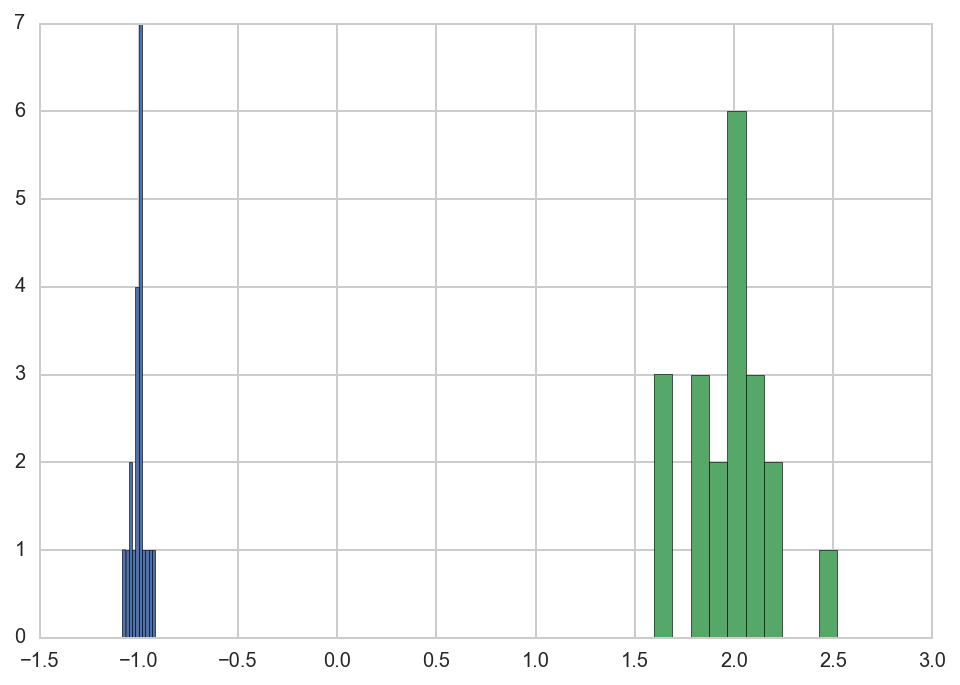

In [23]:
dt.query('name == "p1_center"')['value'].hist()
dt.query('name == "p2_center"')['value'].hist(ax=plt.gca());

## Augment

Tidy dataframe with data function of the independent variable ('x'). Columns include
the data being fitted, best fit, best fit components, residuals, etc.

In [24]:
da = br.augment(Results, var_name='dataset')

In [25]:
da1 = br.augment(Results1, var_name='dataset')

Let's see the results for a single dataset:

In [26]:
da.query('dataset == 0').head()

,x,data,best_fit,residual,"Model(gaussian, prefix='p1_')","Model(gaussian, prefix='p2_')",dataset
0,-10.0,-0.042066,2.941443e-60,0.042066,2.941443e-60,3.836108e-71,0
1,-9.8,-0.085121,1.170886e-57,0.085121,1.170886e-57,7.987095e-69,0
2,-9.6,-0.135447,4.077300e-55,0.135447,4.077300e-55,1.519945e-66,0
3,-9.4,-0.035890,1.242038e-52,0.035890,1.242038e-52,2.643676e-64,0
4,-9.2,0.094643,3.309794e-50,-0.094643,3.309794e-50,4.202711e-62,0


Plotting a single dataset is simplified compared to a manual plot:

In [27]:
da0 = da.query('dataset == 0')

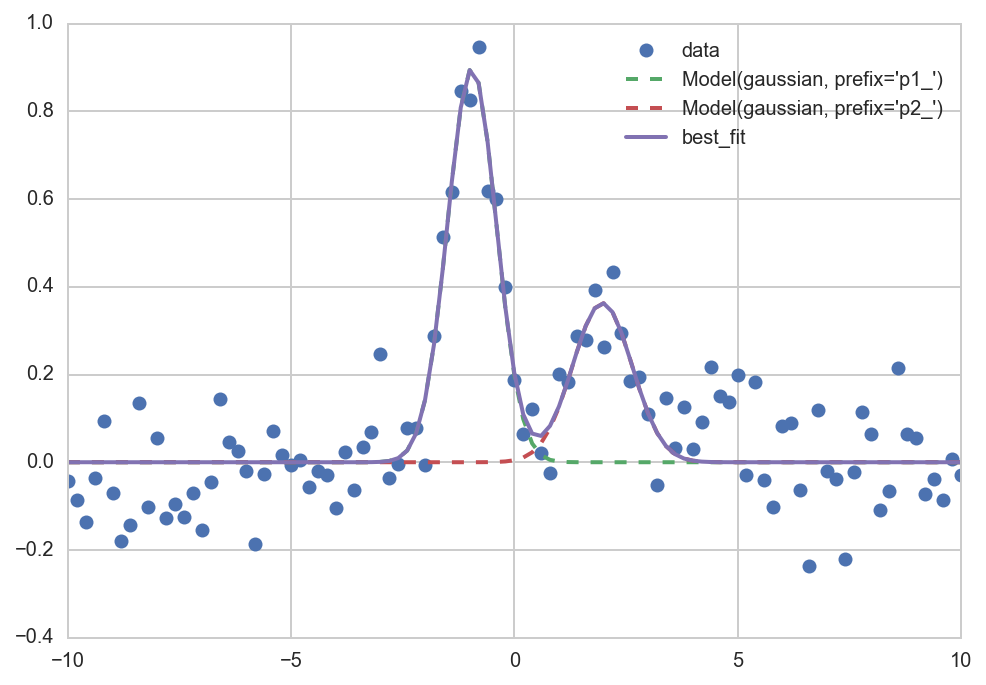

In [28]:
plt.plot('x', 'data', data=da0, marker='o', ls='None')
plt.plot('x', "Model(gaussian, prefix='p1_')", data=da0, lw=2, ls='--')
plt.plot('x', "Model(gaussian, prefix='p2_')", data=da0, lw=2, ls='--')
plt.plot('x', 'best_fit', data=da0, lw=2);
plt.legend()

But keep in mind that, for a single dataset, we could
use the lmfit method as well (which is even simpler):

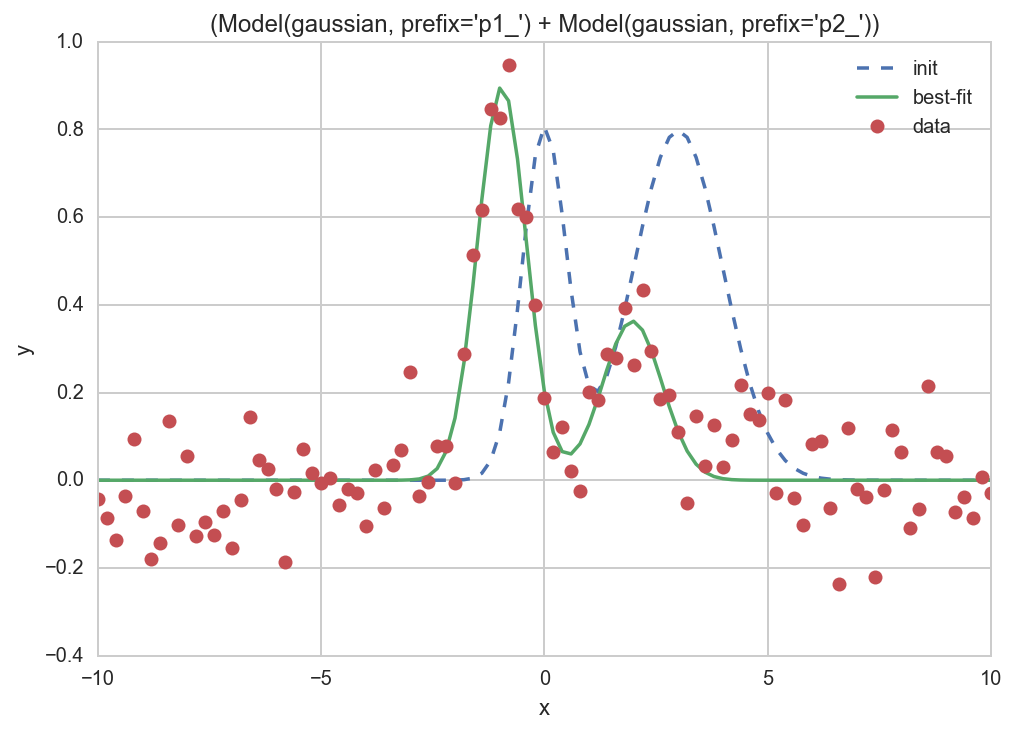

In [29]:
Results[0].plot_fit();

However, things become much more interesting when we want to plot multiple
datasets or models as in the next section.

### Comparison of different datasets

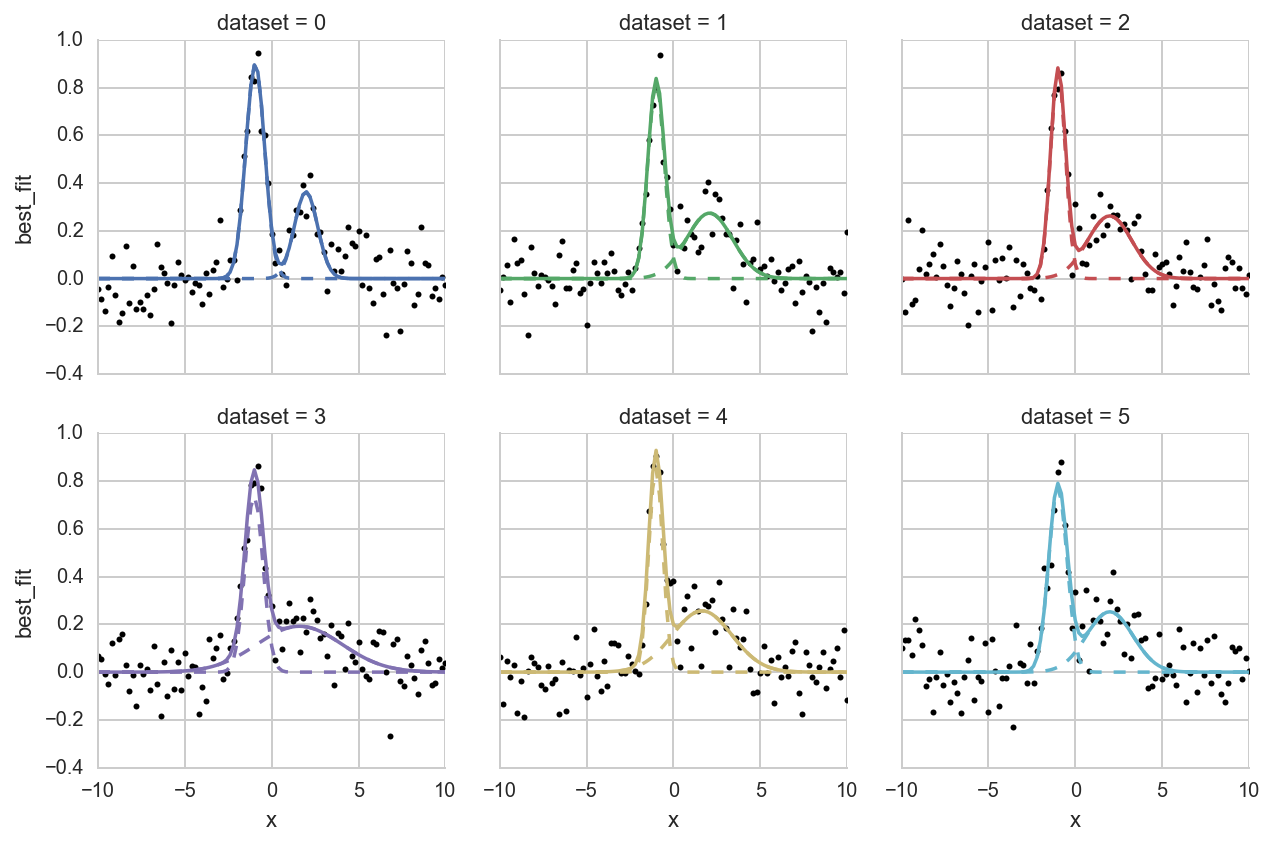

In [30]:
grid = sns.FacetGrid(da.query('dataset < 6'), col="dataset", hue="dataset", col_wrap=3)
grid.map(plt.plot, 'x', 'data', marker='o', ls='None', ms=3, color='k')
grid.map(plt.plot, 'x', "Model(gaussian, prefix='p1_')", ls='--')
grid.map(plt.plot, 'x', "Model(gaussian, prefix='p2_')", ls='--')
grid.map(plt.plot, "x", "best_fit");

### Comparison of one- or two-peaks models

Here we plot a comparison of the two fitted models (one or two peaks)
for different datasets.

First we create a single tidy DataFrame with data from the two models:

In [31]:
da['model'] = 'twopeaks'
da1['model'] = 'onepeak'
da_tot = pd.concat([da, da1], ignore_index=True)

Then we perfom a facet plot with seaborn:

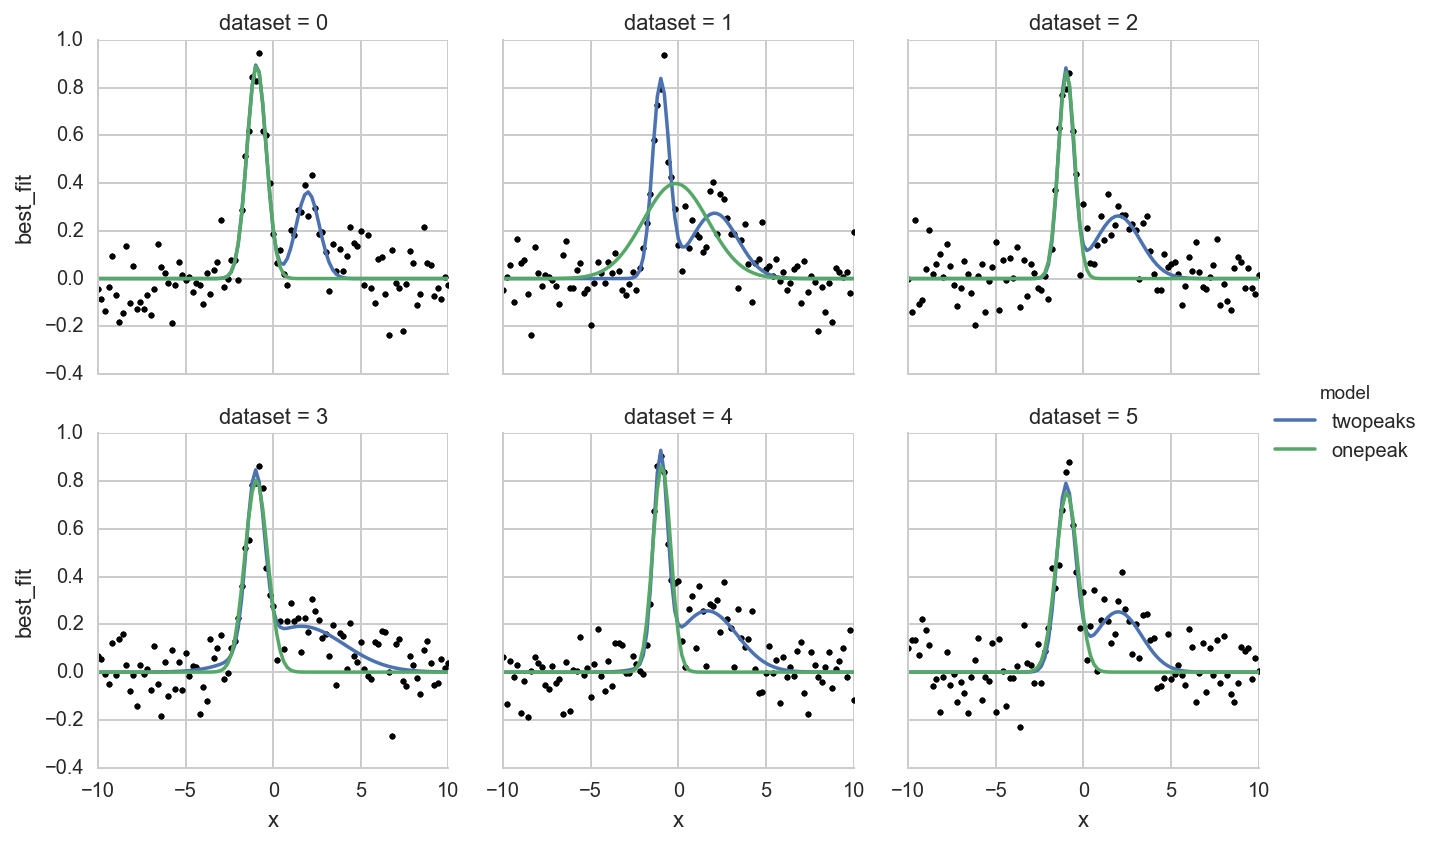

In [32]:
grid = sns.FacetGrid(da_tot.query('dataset < 6'), col="dataset", hue="model", col_wrap=3)
grid.map(plt.plot, 'x', 'data', marker='o', ls='None', ms=3, color='k')
grid.map(plt.plot, "x", "best_fit")
grid.add_legend();

While it is possible (in principle) to create the previous plots 
without tidy data, it would require a great amount of custom 
non-reusable plot code.
With tidy data, instead, complex plots becomes trivial and the syntax is
general.